# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [27]:
# import libraries
import os
import re
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [28]:
def load_data(database_filepath):
    sql_url = 'sqlite:///'+ database_filepath
    table = os.path.basename(database_filepath)
    engine = create_engine(sql_url)
    df = pd.read_sql_table(table, engine)
    
    X = df['message'].values
    y = df[df.columns[4:]].values
    
    #category_names = y.columns
    category_names = list(df.columns)[4:]
    
    return X, y, category_names

In [29]:
database_filepath = 'data/DisasterResponse.db'

X, y, category_names = load_data(database_filepath)

In [30]:
X.shape, y.shape

((26216,), (26216, 35))

In [31]:
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

In [32]:
X_vect

<26216x35121 sparse matrix of type '<class 'numpy.int64'>'
	with 535982 stored elements in Compressed Sparse Row format>

In [8]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        return X
    
    def fit(self, X, y = None, **fit_params):
        return self 

In [33]:
class CaseNormalizer(BaseEstimator, TransformerMixin):
    '''
    CaseNormalizer class: 
        - Feature of machine learning pipeline model
        - custom transformer that transforms a text array to lower case
        and removes white space.

        In: 
            text array
        Out: 
            Pandas Series of transformed text
    '''
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        import pdb
        pdb.set_trace()
        X_vect = vectorizer.fit_transform(X)
        print(X_vect)
        return X_vect

In [34]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    '''
    StartingVerbExtractor class:
        - Feature of machine learning model pipeline
        - Checks whether first word in sentence is a verb

        In: 
            text array
        Out: 
            Pandas DataFrame of tagged text
    '''

    def starting_verb(self, text):
        sentence_list = sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        X_tagged = pd.DataFrame(X_tagged)
        X_tagged[0] = X_tagged[0].astype(int)
        return X_tagged

### 2. Write a tokenization function to process your text data

In [35]:
def tokenize(text):
    '''
    tokenize:
        Split text into words, normalize case, reduce words to their root
        In:
            text - message text from disaster dataset
        
        Out:
            clean_tokens - tokenized and lemmatized text
    '''
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # get list of all urls using regex
    detected_urls = re.findall(url_regex, text)
    
    # replace each url in text string with placeholder
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')

    # tokenize text
    tokens = word_tokenize(text)

    # initate case_normalizer and normalize text
    case_normalizer = CaseNormalizer()
    normalized_tokens = case_normalizer.transform(tokens)
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token and lemmatize text
    clean_tokens = []
    for token in normalized_tokens:
        
        clean_token = lemmatizer.lemmatize(token)
        clean_tokens.append(clean_token)

    return clean_tokens

In [12]:
text = 'The training demonstrated how to   enhance Micro'
tokenize(text)

> /var/folders/9k/mzsl98qj485cy49cyb6gm8c40000gn/T/ipykernel_58836/3209499250.py(19)transform()
     17         import pdb
     18         pdb.set_trace()
---> 19         X = pd.Series(X).apply(lambda x: x.lower().strip()).values
     20         print(X)
     21         return X

ipdb> continue
['the' 'training' 'demonstrated' 'how' 'to' 'enhance' 'micro']


['the', 'training', 'demonstrated', 'how', 'to', 'enhance', 'micro']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [38]:
def build_model():
    '''
        build_model:
            - Build Natural Language Processing ML pipeline model
            - Processes and transforms text messages and applies a classifier

            In:
                - None

            Out: pipeline model
    '''
    pipeline = Pipeline([
        ('features', FeatureUnion([
            
            ('nlp_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('debug', Debug()),
                ('tfidf', TfidfTransformer()),
                ('debug1', Debug())
            ])),

            ('starting_verb', StartingVerbExtractor()),
            ('debug2', Debug()),
            ('case_normalizer', CaseNormalizer()),
            ('debug3', Debug())
        ])),
    
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    return pipeline

In [39]:
pipeline.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('nlp_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x7fe0d9c53b80>)),
                                                   ('debug', Debug()),
                                                   ('tfidf', TfidfTransformer()),
                                                   ('toarray',
                                                    FunctionTransformer(func=<function <lambda> at 0x7fe0d9c530d0>)),
                                                   ('debug1', Debug())])),
                                  ('starting_verb', StartingVerbExtractor()),
                                  ('debug2', Debug()),
                                  ('case_normalizer', CaseNormalizer()),
                                  ('debug3', Debug())])),
  ('clf', MultiOutputClassifier(estimator=RandomForestCl

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [40]:
# split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# train classifier
model = build_model()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

> /var/folders/9k/mzsl98qj485cy49cyb6gm8c40000gn/T/ipykernel_58836/2999287524.py(19)transform()
     17         import pdb
     18         pdb.set_trace()
---> 19         X_vect = vectorizer.fit_transform(X)
     20         print(X_vect)
     21         return X_vect

ipdb> continue
  (0, 7)	1
  (2, 17)	1
  (3, 8)	1
  (4, 22)	1
  (5, 1)	1
  (6, 4)	1
  (7, 18)	1
  (8, 17)	1
  (9, 14)	1
  (10, 10)	1
  (11, 0)	1
  (12, 19)	1
  (13, 10)	1
  (14, 13)	1
  (15, 20)	1
  (16, 15)	1
  (17, 5)	1
  (18, 6)	1
  (19, 17)	1
  (20, 11)	1
  (21, 12)	1
  (22, 9)	1
  (24, 2)	1
  (25, 21)	1
  (26, 2)	1
  (27, 17)	1
  (28, 3)	1
  (29, 14)	1
  (30, 10)	1
  (31, 13)	1
  (32, 16)	1


TypeError: unhashable type: 'csr_matrix'

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [76]:
print(classification_report(y_test, y_pred, target_names=category_names))

                        precision    recall  f1-score   support

               related       0.81      0.97      0.88      4998
               request       0.89      0.44      0.59      1079
                 offer       0.00      0.00      0.00        27
           aid_related       0.78      0.61      0.69      2712
          medical_help       0.71      0.05      0.09       508
      medical_products       0.79      0.07      0.12       341
     search_and_rescue       0.50      0.02      0.04       185
              security       0.00      0.00      0.00       128
              military       0.80      0.06      0.11       208
                 water       0.95      0.21      0.34       413
                  food       0.88      0.38      0.53       715
               shelter       0.84      0.25      0.39       553
              clothing       0.88      0.08      0.15        83
                 money       0.67      0.01      0.03       153
        missing_people       0.00      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
accuracy = (y_pred == y_test).mean().mean()
accuracy

0.9447273202842319

In [85]:
labels = np.unique(y_pred)
labels

array([0, 1])

### 6. Improve your model
Use grid search to find better parameters. 

In [9]:
model.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7f844b4254c0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7f844b4254c0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [11]:
parameters = {
    'clf__estimator__n_estimators': [10],
    'clf__estimator__min_samples_split': [2, 4]
}

cv = GridSearchCV(model, param_grid=parameters, verbose = 1, n_jobs = -1)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7f844b4254c0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             n_jobs=-1,
             param_grid={'clf__estimator__min_samples_split': [2, 4],
                         'clf__estimator__n_estimators': [10]},
             verbose=1)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
y_pred = cv.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred, target_names=category_names))

                        precision    recall  f1-score   support

               related       0.82      0.93      0.87      5013
               request       0.82      0.37      0.51      1107
                 offer       0.00      0.00      0.00        27
           aid_related       0.75      0.50      0.60      2705
          medical_help       0.71      0.12      0.20       503
      medical_products       0.70      0.05      0.09       333
     search_and_rescue       0.61      0.06      0.11       184
              security       0.25      0.01      0.02       123
              military       0.71      0.12      0.21       225
                 water       0.87      0.21      0.34       408
                  food       0.84      0.34      0.48       724
               shelter       0.88      0.23      0.36       559
              clothing       0.59      0.13      0.22        98
                 money       0.50      0.02      0.03       170
        missing_people       1.00      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
accuracy = (y_pred == y_test).mean()
accuracy

related                   0.801648
request                   0.898383
offer                     0.995880
aid_related               0.768843
medical_help              0.924626
medical_products          0.950565
search_and_rescue         0.971773
security                  0.980470
military                  0.969637
water                     0.949496
food                      0.926457
shelter                   0.932865
clothing                  0.988251
money                     0.976808
missing_people            0.988099
refugees                  0.966128
death                     0.957736
other_aid                 0.868172
infrastructure_related    0.937443
transport                 0.956515
buildings                 0.951480
electricity               0.979402
tools                     0.994660
hospitals                 0.990693
shops                     0.996033
aid_centers               0.988862
other_infrastructure      0.956210
weather_related           0.868935
floods              

In [93]:
y_pred = model.predict(X_test)
labels = np.unique(y_pred)
labels

/var/folders/9k/mzsl98qj485cy49cyb6gm8c40000gn/T/ipykernel_11989/343124394.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(X).apply(lambda x: x.lower().strip()).values


array([0, 1])

In [92]:
import numpy as np
labels = np.unique(y_pred)
#confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
confusion_mat = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
accuracy = (y_pred == y_test).mean().mean()

print("Labels:", labels)
print("Confusion Matrix:\n", confusion_mat)
print("Accuracy:", accuracy)

Labels: [0 1]
Confusion Matrix:
 [[6550    3    1]
 [   0    0    0]
 [   0    0    0]]
Accuracy: 0.9447273202842319


<AxesSubplot: >

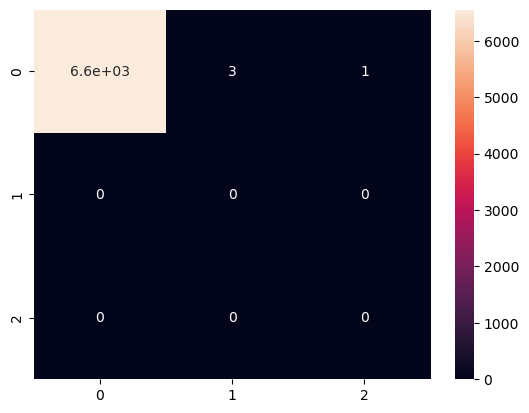

In [97]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)), annot = True)

In [107]:
report = classification_report(y_test, y_pred, target_names=category_names, output_dict = True)
df_classification_report = pd.DataFrame(report).transpose()
#df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
print(df_classification_report)

                        precision    recall  f1-score  support
related                  0.807859  0.970788  0.881861   4998.0
request                  0.887430  0.438369  0.586849   1079.0
offer                    0.000000  0.000000  0.000000     27.0
aid_related              0.780066  0.614676  0.687564   2712.0
medical_help             0.705882  0.047244  0.088561    508.0
medical_products         0.793103  0.067449  0.124324    341.0
search_and_rescue        0.500000  0.021622  0.041451    185.0
security                 0.000000  0.000000  0.000000    128.0
military                 0.800000  0.057692  0.107623    208.0
water                    0.945652  0.210654  0.344554    413.0
food                     0.881967  0.376224  0.527451    715.0
shelter                  0.842424  0.251356  0.387187    553.0
clothing                 0.875000  0.084337  0.153846     83.0
money                    0.666667  0.013072  0.025641    153.0
missing_people           0.000000  0.000000  0.000000  

In [110]:
y_pred = model.predict(X_test)
accuracy = (y_pred == y_test).mean()
overall_accuracy = (y_pred == y_test).mean().mean()
print('Model accuracy by category:\n {}'.format(accuracy))
print('Overall model accuracy: {}'.format(overall_accuracy))

/var/folders/9k/mzsl98qj485cy49cyb6gm8c40000gn/T/ipykernel_11989/343124394.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(X).apply(lambda x: x.lower().strip()).values


Model accuracy by category:
 related                   0.801648
request                   0.898383
offer                     0.995880
aid_related               0.768843
medical_help              0.924626
medical_products          0.950565
search_and_rescue         0.971773
security                  0.980470
military                  0.969637
water                     0.949496
food                      0.926457
shelter                   0.932865
clothing                  0.988251
money                     0.976808
missing_people            0.988099
refugees                  0.966128
death                     0.957736
other_aid                 0.868172
infrastructure_related    0.937443
transport                 0.956515
buildings                 0.951480
electricity               0.979402
tools                     0.994660
hospitals                 0.990693
shops                     0.996033
aid_centers               0.988862
other_infrastructure      0.956210
weather_related           

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [21]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),
    
        ('clf', RandomForestClassifier())
    ])
    
    parameters = {
    'clf__estimator__n_estimators': [10],
    'clf__estimator__min_samples_split': [2, 4]
    }

    cv = GridSearchCV(model, param_grid=parameters, verbose = 1, n_jobs = -1)
    return cv

In [22]:
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [24]:
print(cv.score(X_test, y_test))

0.23298748855660664


In [25]:
accuracy = (y_pred == y_test).mean()
accuracy

related                   0.793409
request                   0.878242
offer                     0.995880
aid_related               0.728563
medical_help              0.924931
medical_products          0.951785
search_and_rescue         0.972536
security                  0.980928
military                  0.967501
water                     0.949954
food                      0.918523
shelter                   0.935002
clothing                  0.985810
money                     0.974519
missing_people            0.987183
refugees                  0.966280
death                     0.955142
other_aid                 0.872597
infrastructure_related    0.932103
transport                 0.952090
buildings                 0.951633
electricity               0.981233
tools                     0.994660
hospitals                 0.989777
shops                     0.994812
aid_centers               0.988251
other_infrastructure      0.954226
weather_related           0.832621
floods              

In [31]:
import numpy as np

In [32]:
class CaseNormalizer (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = pd.Series(X).apply (lambda x: x. lower ()).values
        return np.array(X)

case_normalizer = CaseNormalizer ()

X = ['Implementing', 'a', 'Custom', 'Transformer', 'from', 'SCIKIT-LEARN']
case_normalizer.transform(X)

array(['implementing', 'a', 'custom', 'transformer', 'from',
       'scikit-learn'], dtype=object)

In [31]:
text = word_tokenize('Are we there yet?')
tags = pos_tag(text)

In [37]:
first_word, first_tag = tags[0]
if first_tag in ['VB', 'VBP'] or first_word == 'RT':
    print('True')
else:
    print('False')

False


### 9. Export your model as a pickle file

In [112]:
import pickle as pk
def save_model(model, model_filepath):
    '''
    '''
    pk.dump(model, open(model_filepath, "wb"))

    return
model_filepath = 'ml_model.pkl'
save_model(model, model_filepath)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.